ESTUDIO DEL BITCOIN EN EL MERCADO
---------------------------------------------------------
**Objetivos**: El objetivo principal es el de realizar una gestión de los datos del
mercado del bitcoin para facilitar al usuario una rápida visualizacion 
de los datos más importantes y así facilitar el análisis de los mercados.

Otros objetivos que me propongo son el de buscar alguna relación del precio del 
bitcoin con otros datos que tambien se faciliten en el mercado. Además empleare 
la biblioteca de *Sklearn* para poder obtener predicciones.

**Fuentes de datos**: 
- https://www.blockchain.com/
<img src="../Proyecto_Final_Python/Ilustraciones/blockchain.png" />
- https://data.bitcoinity.org
<img src="../Proyecto_Final_Python/Ilustraciones/Nombre_pagina.png" />

   Estos datos se actualizan cada cierto tiempo (a partir de 1 o 2 horas aproximadamente hacia atras).
   Dependiendo de los datos que se quieran descargar se pueden acceder navegando en el mismo dominio en los apartados que aparecen a la izquierda: 

<img src="../Proyecto_Final_Python/Ilustraciones/Apartados_1.png" alt="drawing" width="125"/> 

   Se pueden descargar haciendo click debajo de la grafica correspondiente en formato csv o xlsx:

<img src="../Proyecto_Final_Python/Ilustraciones/Descarga_datos.png" alt="drawing" width="125" /> 

   En mi caso he investigado como se construye la URL para poder extraer todos los datos deseados directamente mediante el comando de pandas read_csv. Más adelante lo explico en detalle (*datos de entrada*).

**Información básica financiera**:

- Para el siguiente análisis es necesario tener claro los siguientes conceptos:
  - **Price**: Indica el valor en monedas Fiat del Bitcoin (euros, 'EUR' o dolares, 'USD' etc).
  - **Bids**: Es el precio en Fiat por bitcoin o cantidad de Bitcoin por Fiat al que el mercado está dispuesto a comprar. Es el valor al que mejor se puede vender en ese momento.
  - **Asks**: Es el precio en Fiat por bitcoin o cantidad de Bitcoin por Fiat al que el mercado está dispuesto a vender. Es el valor al que mejor se puede comprar en ese momento.
  - **Volume**: Valor en Fiat o en numero de bitcoins que indica la cantidad total del volumen de operaciones ya ejecutadas de compra y venta en ese momento.
  
- Existen diversos indicadores financieros pero yo utilizare exclusivamente las **Bandas bollinger**. Están compuesta por tres:

     - **Banda media**: Se calcula mediante la media móvil con un número dado de períodos
        (normalmente 20). A este número lo denominare *'longitud_mm'*.
        
     - **Banda superior**: Se calcula a partir de la banda media sumando un numero de veces          la desviación estandar. A este número lo denominare *'MULTI'*.
     
     - **Banda inferior**: Se calcula a partir de la banda media restando un numero de veces        la desviación estandar. Este número coincide con el anterior.

  A continuación se encuentran 5 celdas de código que contienen las funciones 
  principales, las librerías y otros elementos necesarios.
  
  Todas ellas se encuentran separadas respectivamente con celdas de Markdown:
  
  1) Librerias y otras herramientas.
  
  2) Datos de entrada.
  
  3) Funciones de extracción y gestión de los datos.
  
  4) Funciones para gráficar.
  
  5) Funciones para libreria de *Sklearn*.
  
  
  Posteriormente, para comprobar los resultados ejecuto varios ejemplos prácticos
  con el orden que se muestran las funciones anteriores. Y además procedo a realizar más
  gráficos y otras variaciones.


### Librerias y otras herramientas
Para dibujar el gráfico de velas utilizaré un modulo que en antiguas versiones se encontraba por defecto en *Matplotlib* pero desafortunamente en la versión actual se encuentra separado y es necesario realizar la instalacion del módulo *Mplfinance*.
Para mayor información de este módulo: https://pypi.org/project/mplfinance/
Además de utilizar todas las librerías que se han utilizado durante la asignatura también empleare *Sklearn* (para los modelos de predicción), *Math* (para ciertos cálculos matemáticos), *IPython* (para visualización gráfica)...

In [ ]:
#Paquete de instalación
!pip install mplfinance

# LIBRERIAS
import time
import os
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd

# Gráficas
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
import matplotlib.ticker as ticker
import seaborn as sns
import mplfinance as mpf
from IPython.display import HTML
from itertools import count

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import math

     |████████████████████████████████| 51kB 1.4MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Datos de entrada
La extracción de datos se ejecuta en función de las necesidades del usuario haciendo cambiar las variables en la url de la web y asi descargando el archivo csv exacto para procesarlo en la función correspondiente. Teniendo en cuenta la siguiente tabla :

<center>
    
Variable | Ejemplo
:--------: | -------       
currency| 'EUR'
exchange | 'bitstamp'
register | 'minute'
timespan | '10m'
    
</center>




Mediante la URL siguiente:

'https:// data.bitcoinity.org /export_data.csv?currency=' + **currency** +
        '&data_type=price&exchange=' + **exchange** + '&r=' + **register** + '&t=l&timespan='+ **timespan**
        
 -> Se obtendra un archivo CSV con los precios en 'EUR' del mercado de 'bitstamp' en los últimos 10 minutos por minuto.
 
Todas los valores disponibles para **timespan** y **register** son:
<center>
    
timespan | register
:--------: | -------      
<img src="../Proyecto_Final_Python/Ilustraciones/timespan.png" alt="drawing" width="250" />|<img src="../Proyecto_Final_Python/Ilustraciones/register.png" alt="drawing" width="75" />  <img src="../Proyecto_Final_Python/Ilustraciones/register2.png" alt="drawing" width="50" /> <img src="../Proyecto_Final_Python/Ilustraciones/register3.png" alt="drawing" width="75" />

</center>


In [ ]:
#### VARIABLES DE ENTRADA DISPONIBLES
# currency: Lista de monedas o dinero fiat
mo = ['AED','ARS','AUD','BRL','CAD','CHF','CLP','CNY','COP','CZK','DKK','EUR','GBP','HKD',
         'HRK','HUF','IDR','ILS','INR','IRR','JPY','KES','KRW','MXN','MYR','NOK','NZD','PHP',
         'PKR','PLN','RON','RUB','RUR','SEK','SGD','THB','TRY','UAH','USD','VEF','XAU','ZAR']

# exchange: Mercados disponibles (los 4 primeros son los más comunes)
# ['bitfinex', 'bitstamp', 'coinbase', 'kraken']
me = ['bitstamp','bitfinex','kraken','coinbase','bit-x','exmo','cex.io','gemini','bitcoin.co.id','bitflyer',
            'bitcoincentral','bit2c','bitcoinde','bitcoinsnorway','bitcurex',
            'bitflyer','bithumb','bitmarketpl','bitmex','bitquick','bitso','btcchina','btce',
            'btcmarkets','campbx','clevercoin','coinfloor','hitbtc','huobi','itbit',
          'korbit','lakebtc','localbitcoins','mercadobitcoin','okcoin','paymium',
          'quadrigacx','therocktrading','vaultoro','wallofcoins','bitbay']

# Otras variables disponibles para la configuracion de ASK y BID:
# Contabilización en bids/asks en criptomonedas o dinero fiat bu ='b' / bu ='c'
bu = ['b','c']

# Porcentajes de bids y asks 1%,5%,10%,20%,50% respectivamente.
bp = ['1','5','10','20','50']

# EJEMPLO DE ENTRADA DE DATOS EN LAS FUNCIONES: 
# currency: mo[11] = 'EUR' # mo[-4] = 'USD'
# exchange: me[0] = 'bitstamp'
# exchanges: me[0:4] = ['bitstamp','bitfinex', 'kraken', 'coinbase']
# register: 'minute' = salto de tiempo en filas (minuto) / 'second' (segundo) / 'day' (dias)
# timespan: '24h'# tamaño del data (ultimas 24h) / '10m' (ult. 10min) / '2y' (ult. 2 años)

# Combinaciones de tiempo recomendadas:
# 'minute' / 'second' con '10m' / '1h' / '6h'
# 'minute' / 'hour' con '24h'
# 'hour' / 'day' el resto

### FUNCIONES DE EXTRACCION Y/O CALCULO DE DATOS
Existen más funciones pero las principales son las siguientes:

Función | Resumen
:--------: | -------       
getDataPrice| Extraer valores de precios de mercado
getDataAB | Extraer valores de BID y ASK
otherDataBitcoin| Datos estadisticos relacionados con las operaciones
AskBid_CALCULUS | Calculos relacionados con BID y ASK
GeneralDataExchanges| Datos de varios mercados
bol | Calcular bandas bollinger
OpenCloseOtherPrice| Apertura / cierre y otros datos para la predicción







In [ ]:
##############################################################################
############# FUNCIONES DE EXTRACCION Y/O CALCULO DE DATOS
##############################################################################

#################### Format_time ##########################
# Función que es llamada en las demás funciones.
# Dependiendo el espacio temporal escogido, 
# solo nos interesará ciertas marcas temporales (time_leyend).
# Asi evitamos saturar futuras gráficas u otro tipo de información 
# que nos interese mostrar.

def Format_time(timespan):
    if timespan in ['10m','1h','6h']:
        time_leyend = '%H:%M:%S'
    elif timespan == '24h':
        time_leyend = '%H:%M'
    elif timespan in ['6m','2y','5y']:
        time_leyend = '%y-%m-%d'
    else:
        time_leyend = '%y-%m-%d' + ' %H:%M:%S'
    return time_leyend

##################### getDataPrice ########################
# Funcion que recoge datos de:
# Precio último, máximo, mínimo y volumen en el 
# lapso de tiempo ('timespan'), mercado ('exchange'), 
# moneda fiat ('currency') con saltos temporales de 'register'.

def getDataPrice(currency, exchange, register, timespan):
    
    time_leyend = Format_time(timespan)
    
    price = pd.read_csv(
        'https://data.bitcoinity.org/export_data.csv?currency='+ currency +
        '&data_type=price&exchange=' + exchange + '&r=' + register + '&t=l&timespan='
        + timespan,sep=',',index_col = 0, header = 0, engine = 'python')
    
    price.columns = ['LAST PRICE', 'High','Low']
    
    try:
        volume = pd.read_csv(
            'https://data.bitcoinity.org/export_data.csv?currency=' + currency +
            '&data_type=price_volume&exchange=' + exchange + '&r=' + register +
            '&t=lb&timespan=' + timespan + '&vu=curr',sep = ',',index_col = 0,
            usecols = ["Time","volume"], header = 0, engine = 'python')

        volume.columns = ['Volume']
        price = price.merge(volume, on='Time', how='inner')
        
    except ValueError: # En algunos se produce error en la lectura
        volume = pd.DataFrame(index=price.index.copy,columns=['Volume'])
        price = price.merge(volume, on='Time', how='inner')
    
    #time
    price['Time_plot'] = pd.to_datetime(price.index)
    price['Time_plot'] = price['Time_plot'].dt.strftime(time_leyend)
    ###

    return price

######################### getDataAB #############################
# Funcion que recoge datos:
# Ask y Bid con el % del mercado ('bp') y moneda fiat o bitcoin ('bu') 
# en el lapso de tiempo ('timespan'), mercado ('exchange'), 
# moneda fiat ('currency') y con saltos temporales de 'register'.

def getDataAB(currency, exchange, register, timespan,bu,bp):
    
    time_leyend = Format_time(timespan)
    
    asks = pd.read_csv('https://data.bitcoinity.org/export_data.csv?bp='+bp+'&bu='+bu+
    '&currency='+currency+'&data_type=bidask_sum&exchange='+exchange+
        '&r='+register+'&t=l&timespan='+timespan,sep=',',
        index_col=0,usecols=["Time","asks", "bids"],header=0, engine='python')
    
    # Se separa el bid del ask                        
    bids = asks.copy()

    del bids['asks'],asks['bids']

    bids = bids.rename(columns = {'bids':'B' + bp + '%' + bu})
    asks = asks.rename(columns = {'asks': 'A' + bp + '%' + bu})
    
    # time
    asks['Time_plot'] = pd.to_datetime(asks.index)
    asks['Time_plot'] = asks['Time_plot'].dt.strftime(time_leyend)
    bids['Time_plot'] = pd.to_datetime(bids.index)
    bids['Time_plot'] = bids['Time_plot'].dt.strftime(time_leyend)
    ##
    return asks,bids

################### otherDataBitcoin #################
# Funcion que recoge datos:
# Ask y Bid con el % del mercado ('bp') y moneda fiat o bitcoin ('bu') 
# en el lapso de tiempo ('timespan'), mercado ('exchange'), 
# moneda fiat ('currency') y con saltos temporales de 'register'.

def otherDataBitcoin(register,timespan):
    
    time_leyend = Format_time(timespan)
    
    # Operaciones por minuto
    tradespm = pd.read_csv(
        'https://data.bitcoinity.org/export_data.csv?c=e&data_type=tradespm&r=' + register + 
        '&s=bundle&t=a&timespan='+ timespan,sep=',', index_col=0,usecols = ['Time',
        'bitfinex','bitstamp','coinbase', 'kraken'], header = 0, engine = 'python')
    tradespm.columns = ['bitfinex T_min','bitstamp T_min','coinbase T_min', 'kraken T_min']
    
    # Volumen por operación
    tra_volume = pd.read_csv(
          'https://data.bitcoinity.org/export_data.csv?c=e&data_type=volume&r=' + register + 
            '&t=b&timespan='+ timespan,sep=',', index_col=0,usecols = ['Time','bitfinex',
        'bitstamp','coinbase', 'kraken'], header = 0, engine = 'python')
    tra_volume.columns = ['bitfinex V_T','bitstamp V_T','coinbase V_T', 'kraken V_T']
    
    tra_volume = tra_volume.merge(tradespm, on='Time', how='outer')
    
    #time
    tra_volume['Time_plot'] = pd.to_datetime(tra_volume.index)
    tra_volume['Time_plot'] = tra_volume['Time_plot'].dt.strftime(time_leyend)
    ###
    return tra_volume

################# homeTime ###################
# Completa los valores de los minutos que faltan
# con una media entre el dato del min. anterior y
# el posterior. Concretamente ocurre con los datos 
# extraidos de ASK y BID cuando 'register' = 'minute'.

def homeTime(values,times,name,timespan):
    
    A = []
    C = []
    
    # Bucle para hacer una lista con la diferencia entre cada celda contigua
    for i in range(0,len(times)-1):
        difer = abs(int(times[i][3:5]) - int(times[i+1][3:5]))
        
        if difer > 10: # Si la diferencia es mayor de 10 habrá pasado de 60 
            # y se reseteo la cuenta. Por tanto se realiza la corrección:
            difer = (abs(60-int(times[i][3:5]))+int(times[i+1][3:5]))
        A.append(difer)
        
    # Se procede mediante un bucle a incluir los tiempos que faltan:
    for i in range(0, len(values)-1):
        dim_f = A[i]
        B = []
        if dim_f > 1: # Si la diferencia es mayor que uno, faltan datos
            # Se realiza el calculo de manera progresima, 'suavizando' la linea
            # rellenando los tiempos que faltan con valores intermedios de los
            # que si se tienen datos.
            if values[i] > values[i+1]: 
                base =(values[i] - values[i+1])/dim_f
                B.append(values[i])
                
                # Se resta el calculo base teniendo en cuenta el valor anterior
                # y asi sucesivamente
                
                for j in range(0,dim_f-1):
                    B.append(B[-1]-base)
                B.pop(0)
                
            else:
                
                base = ( values[i+1] - values[i] )/dim_f
                B.append(values[i])
                for j in range(0,dim_f-1):
                    B.append(B[-1]+base)
                B.pop(0)
        
        C = C + [values[i]] + B #+ [values[i+1]]
    
    # Una vez se tiene la lista completa se suma el ultimo valor que no
    # se tuvo en cuenta
    
    C = C + [values[-1]]
    
    # Se crea la lista al completo de tiempos:
    if timespan == '24h': 
        
        # en caso de ser 24horas se conoce que en algun punto pasa por las 00:00
        # y es necesario corregirlo:
        
        idx = pd.timedelta_range(start=times[0]+':00',end= '23:59:00' ,freq='min', name='Time')
        idx2 = pd.timedelta_range(start='00:00:00',end= times[-1]+':00',freq='min', name='Time')
        idx = idx.to_list() + idx2.to_list()
        idx = pd.to_timedelta(idx)

    else:
        idx = pd.timedelta_range(start=times[0],end= times[-1] ,freq='min', name='Time')
    
    # Finalmente se obtiene el dataframe total y se vuelve a construir la serie 'Time_plot'.
    values = pd.DataFrame({name: C,'Time_plot':idx})

    values['Time_plot'] = values['Time_plot'].astype(str).str[-18:-10]
    
    return values

################# AskBid_CALCULUS ###################
# Para buscar cualquier relación realizo
# varios calculos con los datos del ASK y BID:
# - SPREAD: Resta de Ask y Bid correspondientes al %
# - TOTAL: Suma de Ask y Bid correspondientes al %
# - RELATION ASK/BID: Relación ask/bid
# - MEDIAS Y DESVIACIONES TIPICAS DE LO ANTERIOR

def AskBid_CALCULUS(ask,bid):
    
    # Se recogen las denominaciones de cada columna que cambian en funcion bu y bp
    names_ask=list(ask)
    names_bid=list(bid)
    
    CALCULUS = pd.DataFrame()
    
    # se calculan las siguientes operaciones con los nombres correspondientes
    CALCULUS['SPREAD ' + names_bid[0][1:]] = ask[names_ask[0]] - bid[names_bid[0]]
    CALCULUS['TOTAL ' + names_bid[0][1:]] = bid[names_bid[0]] + ask[names_ask[0]]
    CALCULUS['RELATION ASK/BID' + names_bid[0][1:]] =  ask[names_ask[0]] / bid[names_bid[0]]
    
    # Medias
    AVERAGE_AB = CALCULUS.mean().copy()
    
    #Desviaciones tipicas
    DESVEST_AB = CALCULUS.std().copy()
    CALCULUS['Time_plot'] = ask['Time_plot'].copy()
    
    return CALCULUS,AVERAGE_AB,DESVEST_AB

################# GeneralDataExchanges ###################
# Extrae datos básicos de cada mercado como medias,
# desviaciones tipicas, totales, precios más altos, 
# más bajos, en que momentos... 
# Se puede recurrir a la lista de mercados
# del apartado de Datos de entrada para introducir
# directamente (más de uno).

def GeneralDataExchanges(currency,exchanges,register, timespan):
    
    EXCHANGES_PRICE = {'EXCHANGE':[],'AVERAGE PRICE':[],'DESVEST PRICE':[],'TOTAL VOLUME':[],
                       'AVERAGE VOLUME':[],'LAST PRICE':[],'LA.P. TIME':[],
                       'HIGHEST PRICE':[],'H.P. TIME':[],'LOWEST PRICE':[],'LO.P. TIME':[],
                 'LAST VOLUME':[],'LA.V. TIME':[],'HIGHEST VOLUME':[],
                'H.V. TIME':[],'LOWEST VOLUME':[],'LO.V. TIME':[]}
    
    TV_TM = otherDataBitcoin(register, timespan)
    exchangePrice={}
    
    for i in exchanges:
        exchangePrice[i]=((getDataPrice(currency, i, register, timespan)))
    
    EXCHANGES_PRICE['EXCHANGE']= exchanges
    
    for i in exchangePrice:
        
        # MAXIMOS
        a1, a2 = exchangePrice[i][['LAST PRICE','Volume']].max()
        EXCHANGES_PRICE['HIGHEST PRICE'].append(a1)
        EXCHANGES_PRICE['HIGHEST VOLUME'].append(a2)
        
        a1, a2 = exchangePrice[i][['LAST PRICE','Volume']].idxmax()
        EXCHANGES_PRICE['H.P. TIME'].append(exchangePrice[i]['Time_plot'][a1])
        EXCHANGES_PRICE['H.V. TIME'].append(exchangePrice[i]['Time_plot'][a2])

        # MINIMOS
        a1, a2 = exchangePrice[i][['LAST PRICE','Volume']].min()
        EXCHANGES_PRICE['LOWEST PRICE'].append(a1)
        EXCHANGES_PRICE['LOWEST VOLUME'].append(a2)
        
        LP_min, Vol_min = exchangePrice[i][['LAST PRICE','Volume']].idxmin()
        EXCHANGES_PRICE['LO.P. TIME'].append(exchangePrice[i]['Time_plot'][LP_min])
        EXCHANGES_PRICE['LO.V. TIME'].append(exchangePrice[i]['Time_plot'][Vol_min])
        
        # MEDIAS
        a1, a2 = exchangePrice[i][['LAST PRICE','Volume']].mean()
        EXCHANGES_PRICE['AVERAGE PRICE'].append(a1)
        EXCHANGES_PRICE['AVERAGE VOLUME'].append(a2)
        
        # DESVIACION TIPICA
        EXCHANGES_PRICE['DESVEST PRICE'].append(exchangePrice[i]['LAST PRICE'].std())
        
        # SUMA TOTAL
        EXCHANGES_PRICE['TOTAL VOLUME'].append(exchangePrice[i]['Volume'].sum())
        
        # ULTIMAS POSICIONES
        EXCHANGES_PRICE['LAST PRICE'].append(exchangePrice[i]['LAST PRICE'][-1])
        EXCHANGES_PRICE['LA.P. TIME'].append(exchangePrice[i]['Time_plot'][-1])
        EXCHANGES_PRICE['LAST VOLUME'].append(exchangePrice[i]['Volume'][-1])
        EXCHANGES_PRICE['LA.V. TIME'].append(exchangePrice[i]['Time_plot'][-1])
        
    INFORMATION_EXTEND = pd.DataFrame(EXCHANGES_PRICE)
    INFORMATION_EXTEND = round(INFORMATION_EXTEND,4)

    SUMMARY = INFORMATION_EXTEND[['EXCHANGE','AVERAGE PRICE','TOTAL VOLUME']].copy()
    
    SUMMARY['RANGO DE PRECIOS'] = ((round(INFORMATION_EXTEND['AVERAGE PRICE'] - 
                                   INFORMATION_EXTEND['DESVEST PRICE'],4).astype(str)) +
    [' - '] * len(me[0:4]) + (round(INFORMATION_EXTEND['AVERAGE PRICE'] + 
                              INFORMATION_EXTEND['DESVEST PRICE'],4).astype(str)))
    SUMMARY['AVERAGE TRADEpm'] = [TV_TM[i + ' T_min'].mean() for i in exchanges]
    SUMMARY['TOTAL VOL. TRADE'] =  [TV_TM[i + ' V_T'].sum() for i in exchanges]
    
    SUMMARY = round(SUMMARY,4)
    SUMMARY = SUMMARY.set_index('EXCHANGE')
    return SUMMARY,INFORMATION_EXTEND

################# bol ###################
# Calcula el indicador de las bandas de bollinger:
# MM
# B.I.
# B.S.
# Datos predeterminados:
# ncells = 5 # dimensiones del estudio (ejemplo: 1min cada celda, ncells=5 -> 5min)
# longitud_mm = 20 # numero de datos para hacer mm
# MULTI = 2

def bol(ncells,longitud_mm,MULTI,price,timespan):
    
    time_leyend = Format_time(timespan)
    
    # Declaración de variables
    calculate=[]
    mm = []
    bi = []
    bs = []
    
    # Numero de filas
    [rows,_] = price.shape

    # Realiza el calculo en lo posible de todas las celdas segun el valor del estudio de ncells
    # dando prioridad a las ultimas.
    
    for i in range(ncells,rows+1):
            supply = price['LAST PRICE'].iloc[i-ncells:i]
            calculate.append((supply.max() + supply.min() + supply.iloc[-1])/3)

    calculate = pd.Series(calculate)

    for i in list(range(longitud_mm,len(calculate)+1)):
        rango = calculate.iloc[i-longitud_mm:i]
        prom = rango.mean()
        desvest = MULTI * rango.std(ddof=1)
        mm.append(prom)
        bi.append(prom - desvest)
        bs.append(prom + desvest)


    lost = longitud_mm+ncells-2 # Valores perdidos longitud_mm+ncells-2
    bollinger = pd.DataFrame({'MM' : [0]*lost +mm,
                        'B.I.' : [0]*lost +bi,
                      'B.S.': [0]*lost +bs})

    #time
    bollinger['Time_plot'] = pd.to_datetime(price.index)
    bollinger['Time_plot'] = bollinger['Time_plot'].dt.strftime(time_leyend)
    bollinger['Time_plot'] = pd.to_datetime(bollinger['Time_plot'],yearfirst=True)
    bollinger = bollinger.set_index('Time_plot')
    ###
    
    bollinger = bollinger.round(2)
    return(bollinger,lost)

################# OpenClose ###################
# Calcula la apertura y el cierre en un periodo
# teniendo en cuenta el precio del anterior 
# periodo. 

def OpenClose(price):
    
    # Copia los datos excepto el primero para tener las mismas dimensiones.
    OC_price =  price.iloc[1:].copy()
    OC_price['Open'] = 0
    OC_price['Close'] = 0
    for i in range(1, len(price['LAST PRICE'])):
        OC_price.loc[price.index[i], 'Open'] = price['LAST PRICE'][i-1]
        OC_price.loc[price.index[i], 'Close'] = price['LAST PRICE'][i]
    return OC_price

################# OpenCloseOtherPrice ###################
# Calcula la apertura y el cierre en un periodo y calcula
# datos necesarios para realizar las operaciones de regresión.

def OpenCloseOtherPrice(currency, exchange, register, timespan):
    price = getDataPrice(currency, exchange, register, timespan)
    
    OC_price = OpenClose(price)
    
    other = OC_price.loc[:,['LAST PRICE','Volume', 'Time_plot']]
    del OC_price['LAST PRICE']
    OC_price['Time_plot'] = pd.to_datetime(OC_price['Time_plot'],yearfirst=True)
    OC_price = OC_price.set_index('Time_plot')
    # High Low Percentage ('HL_PCT') y Percentage Change ('PCT_change').
    other['HL_PCT'] = (OC_price['High'] - OC_price['Low']) / OC_price['Close'] * 100.0
    other['PCT_change'] = (OC_price['Close'] - OC_price['Open']) / OC_price['Open'] * 100.0
    other['Time_plot'] = pd.to_datetime(other['Time_plot'],yearfirst=True)
    
    other=other.set_index('Time_plot')
    
    return OC_price, other

### FUNCIONES PARA REALIZACIÓN DE GRÁFICAS

Función | Resumen
:--------: | -------       
line_bar| Grafico de lineas y de barras
graph_pie_exchanges | Grafico de queso de los mercados
graph_heat_map| Mapa de calor
graph3_rel_TotalAB_price | Gráfico de tres ejes
data_graph3_mo_me | Extraccion de grafico en bucle

In [ ]:
##############################################################################
############# FUNCIONES PARA REALIZACIÓN DE GRÁFICAS Y OTROS 
##############################################################################

# GRÁFICO DE BARRAS
def line_bar(dat,time_start,time_final):
    
    fig, ax = plt.subplots(figsize=(15,6))
    g = sns.lineplot(x='Time_plot',  y='LAST PRICE', data=dat[time_start:time_final], 
                     ax=ax,marker='o', markersize=10)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    ax2 = ax.twinx()
    g = sns.barplot(x='Time_plot',  y='Volume', data=dat[time_start:time_final], 
                    ax=ax2,alpha=.5)
    ax.set_title('Evolucion del precio y volumen', fontsize = 17)
    plt.show()

# GRÁFICO DEL QUESITO
def graph_pie_exchanges(TABLE):
    plt.title(TABLE.name)
    plt.pie(TABLE,labels=TABLE.index,autopct="%0.1f %%", explode=(0, 0, 0, 0.1))
    plt.show()

# MAPA DE CALOR
# Element: Tiene que ser el nombre de una columna como 'LAST PRICE', 'volume'.
def graph_heat_map(TABLE,element):
    
    # lista de meses para poder tener una mejor visualización sin ser números
    months = {'01': '01_Jan', '02': '02_Feb', '03': '03_Mar', '04': '04_Apr', '05': '05_May',
            '06': '06_Jun', '07': '07_Jul', '08': '08_Aug', '09': '09_Sep', '10': '10_Oct', 
              '11': '11_Nov', '12': '12_Dec'}
    
    # Se extraen los años
    TABLE['year'] = TABLE.index.str.split('-', 3).str[0].str.strip()
    
    # Se extraen los meses y aplica el cambio de nombre correspondiente
    TABLE['month'] = TABLE.index.str.split('-', 3).str[1].str.strip()
    TABLE['month'] = TABLE['month'].apply(lambda x: months[x])

    # Se seleccionan las columnas para el mapa de calor
    TABLE = TABLE.pivot("month", "year", element)
    plt.title(element)
    ax = sns.heatmap(TABLE)
    #display(ax)
    sns.set()
    
# FUNCIÓN QUE REALIZA LA EXTRACCION DE DATOS DE UN PERIODO
# Y REALIZA LA GRAFICA DE 3 EJES CON LA EVOLUCION DEL BITCOIN 
# RESPECTO DEL VOLUMEN DE ASK+BID Y SU RELACION A/B CON LOS TIEMPOS SOLICITADOS.
# -> INPUT: MONEDA, MERCADO, SALTO DE TIEMPO, RANGO DEL ESTUDIO, TIPO DE CONTABILIZACION
# DEL ASK Y BID, SU PORCENTAJE Y EL DIRECTORIO PARA GUARDAR LOS DATOS DE SALIDA.
# -> OUTPUT: FICHERO EXCEL CON LOS DATOS OBTENIDOS Y GRAFICA.
    
def graph3_rel_TotalAB_price(currency,exchange,register,timespan,bu,porcent,FOLDER):
          
    NAME_FILE = 'Porcentaje_'+ porcent  + '_Fecha_' + datetime.now().strftime('%H_%M_%S_%d_%m_%Y')
    price = getDataPrice(currency,exchange, register, timespan)
    
    print(price.shape)
    ask,bid = getDataAB(currency,exchange, register, timespan,bu,porcent)

    # Se extraen los nombres
    names_ask=list(ask)
    names_bid=list(bid)
    
    # En caso de haber saltos de minutos, es necesario aplicar la función homeTime
    # asi se evita la perdida de información al combinar los dataset correspondientes.
    # Ya que el dataset correspondiente a los precios nunca faltan datos entre minuto y minuto
    # sin embargo con ASK y BID si ocurre.
    
    if register == 'minute' and not timespan == '24h': #
        ask = homeTime(ask[names_ask[0]],ask['Time_plot'],names_ask[0],timespan)
        bid = homeTime(bid[names_bid[0]],bid['Time_plot'],names_bid[0],timespan)
    
    price = price.merge(ask['Time_plot'])

    ask = ask.merge(price['Time_plot'])
    bid = bid.merge(price['Time_plot'])

    datos,_,_=AskBid_CALCULUS(ask,bid) #suma y relacion
    
    combine = price.merge(bid.merge(ask.merge(datos)))
    
    # Se guarda las dimensiones de ask para tenerlas en cuenta en las dimensiones del gráfico
    dim = ask.shape
    
    # Se guardan los datos en un fichero excel para su posterior estudio.
    combine.to_excel(FOLDER + NAME_FILE +register+timespan+'.xlsx', sheet_name='sum')
    
    # Cuantas más filas, más saltos habrá en el tiempo y por tanto mayor número de etiquetas
    # en el eje X y por se hace más agradable a la vista un gráfico más grande en ese eje.
    
    fig, ax1 = plt.subplots(figsize=(dim[0]*0.25,25)) 
    
    ax2 = ax1.twinx()

    ax3 = ax2.twinx()

    # Grafico de barras:
    # Interesa ver la evolución del total de volumen pero no necesariamente sus valores
    # numericos (para ver como afecta al resto de ejes)
    
    lns1=sns.barplot(x = price['Time_plot'],
                y = datos['TOTAL ' +porcent +'%'+bu],#/datos['TOTAL 5%'].min()
                color='#004488',
                label = 'A+B',
                ax=ax1)
    
    ax1.axes.get_yaxis().set_visible(False) # Hace invisible el eje para este grupo de datos
    
    

    # Se realiza la escala con su minimo y su máximo
    ax1.set(ylim=(datos['TOTAL '+porcent +'%'+bu].min(), datos['TOTAL '+porcent +'%'+bu].max()))
    
    
    # Grafico de lineas:
    # Para ver la evolución del SPREAD
    lns2=sns.lineplot(x=price['Time_plot'], 
                 y=datos['SPREAD '+porcent +'%'+bu],
                 color='r',
                 marker="o",
                 label = 'SPREAD',
                 ax=ax2)
    # Se dispone el eje al lado derecho
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    
    # Grafico de lineas:
    # Para ver la evolución del precio
    lns3=sns.lineplot(x=price['Time_plot'], 
                 y=price['LAST PRICE'], 
                 color='y',
                 marker="x",
                 label = 'PRICE',
                 ax=ax3)
    # Se dispone el eje al lado izquierdo
    ax3.yaxis.set_label_position("left")
    ax3.yaxis.tick_left()
    
    # Se juntan las leyendas
    lines, labels= ax1.get_legend_handles_labels()

    lines2, labels2 = ax2.get_legend_handles_labels()

    lines3, labels3 = ax3.get_legend_handles_labels()

    ax3.legend(lines + lines2+ lines3, labels + labels2+ labels3, loc=0)
    
    # Se rotan las etiquetas para el eje x
    for item in lns1.get_xticklabels():
        item.set_rotation(60)

    plt.show()
    sns.set()
    
    # Se guarda la figura graficada en el directorio solicitado
    fig.savefig(FOLDER + NAME_FILE + register+timespan +'.png',bbox_inches='tight')

    
# FUNCIÓN DE EXTRACCION EN BUCLE INFINITO DE PRECIOS Y RELACIONES CON EL BID Y ASK DEL BITCOIN.
# INPUTS: MONEDA, MERCADO, PORCENTAJE DE BID Y ASK, DIRECTORIO PARA GUARDAR LOS DATOS.
# OUTPUTS: 
# -> EXCELS DE DATOS DEL MERCADO BITCOIN:
# - A 10MIN (POR MINUTO)
# - A 1HORA (POR MINUTO)
# - A 6HORAS (POR MINUTO Y POR HORA)
# - A 24HORAS (POR MINUTO Y POR HORA)
# -> GRAFICAS DE LA EVOLUCION DEL BITCOIN RESPECTO DEL VOLUMEN DE ASK+BID Y SU RELACION A/B
# CON LOS MISMOS TIEMPOS QUE LOS EXCELS EXTRAIDOS.

def data_graph3_mo_me(currency,exchange,por, directory):
    n = datetime.now().strftime('%H_%M_%S')
    
    time.sleep(0.1)
    
    minuto_a = n[3:5]
    hora_b = n[0:2]
    hora_c = n[0:2]
    hora_d = n[0:2]
    
    # Despliegue de las carpetas donde iran alojados los datos generados
    FOLDERS =[]
    try:
        # Crea los ficheros necesarios para ordenar los datos extraidos
        FOLDERS.append(directory +'10m/')
        os.mkdir(FOLDERS[0])
        FOLDERS.append(directory +'1h/')
        os.mkdir(FOLDERS[1])
        
        FOLDERS.append(directory +'6h/')
        os.mkdir(FOLDERS[2])
        
        time.sleep(0.2)
        FOLDERS.append(FOLDERS[2] + 'minute/')
        os.mkdir(FOLDERS[3])
        FOLDERS.append(FOLDERS[2] + 'hour/')
        os.mkdir(FOLDERS[4])
        
        FOLDERS.append(directory +'24h/')
        os.mkdir(FOLDERS[5])
        
        time.sleep(0.2)
        FOLDERS.append(FOLDERS[5] + 'minute/')
        os.mkdir(FOLDERS[6])
        FOLDERS.append(FOLDERS[5] + 'hour/')
        os.mkdir(FOLDERS[7])

        while(True):
            time.sleep(2)
            n = datetime.now().strftime('%H_%M_%S')
            if  (minuto_a != n[3:5] and int(n[3:5]) % 10 == 0):
                print('GRAFICA Y EXCEL DE 10 MIN')
                print(n)
                minuto_a = n[3:5]
                graph3_rel_TotalAB_price(currency,exchange, 'minute', '10m',bu[1],por,FOLDERS[0])

            time.sleep(0.5)
            if  (hora_b != n[0:2] and int(n[0:2]) % 2 == 0):
                print('GRAFICA Y EXCEL DE 1 HORA')
                print(n)
                hora_b=n[0:2]
                graph3_rel_TotalAB_price(currency,exchange, 'minute', '1h',bu[1],por,FOLDERS[1])

            time.sleep(0.5)
            if  (hora_c != n[0:2] and int(n[0:2]) % 6 == 0):
                print('GRAFICA Y EXCEL DE 6 HORAS')
                print(n)
                hora_c=n[0:2]
                graph3_rel_TotalAB_price(currency,exchange, 'minute', '6h',bu[1],por,FOLDERS[3])
                graph3_rel_TotalAB_price(currency,exchange, 'hour', '6h',bu[1],por,FOLDERS[4])
            time.sleep(0.5)  
            if  (hora_d != n[0:2] and int(n[0:2]) % 22 == 0):
                print('GRAFICA Y EXCEL DE 24 HORAS:')
                print(n)
                hora_d=n[0:2]
                graph3_rel_TotalAB_price(currency,exchange, 'minute', '24h',bu[1],por,FOLDERS[6])
                graph3_rel_TotalAB_price(currency,exchange, 'hour', '24h',bu[1],por,FOLDERS[7])
            time.sleep(0.5)
        
    except OSError:
        print("La creación del directorio %s falló" % directory)


### FUNCIÓN PARA REALIZACIÓN DE PREDICCIONES


<center>
    
Variable | Valores ejemplo
:--------: | -------       
currency| 'EUR'
exchange | 'bitstamp'
register| 'minute'
timespan | '24h'
bu | 'c'
porcent | 'u'
model | 'line'
supply | Datos de apoyo


    
</center>

Modelos para escoger en la predicción e introducir como entrada a la función:
- Lineal:  'line'
- Polinomica al cuadrado: 'pol2'
- Polinomica al cubo: 'pol3'
- KNN: 'knn'

Los datos de apoyo (o supply) son datos con las mismas dimensiones que los datos principales
y se emplea para experimentar con la herramienta de predicción.


In [ ]:
##############################################################################
############# FUNCION PARA REALIZACIÓN DE PREDICCIONES
##############################################################################

def predictModel(currency, exchange, register, timespan,bu,porcent,model,supply):
    OC_price,other = OpenCloseOtherPrice(currency, exchange, register, timespan)
    
    confidence = [] #LISTA DE CONFIANZA DONDE SE ALMACENAN LAS CONFIANZAS DE CADA MODELO
    ####
    ask,bid = getDataAB(currency,exchange, register, timespan,bu,porcent)

    names_ask=list(ask)
    names_bid=list(bid)

    if register == 'minute':
        ask = homeTime(ask[names_ask[0]],ask['Time_plot'],names_ask[0],timespan)
        bid = homeTime(bid[names_bid[0]],bid['Time_plot'],names_bid[0],timespan)
    
    datos,_,_=AskBid_CALCULUS(ask,bid) #suma y relacion
    #if register == 'day':
    datos['Time_plot'] = pd.to_datetime(datos['Time_plot'],yearfirst=True)
    display(datos)
    datos=datos.set_index('Time_plot')
    other[supply] = datos[supply+porcent+'%'+bu].copy()
    
    # OPERACIONES PARA MACHINE LEARNING
    # Se quitan posibles valores que falten con NAN
    other.fillna(value=-99999, inplace=True)

    # Calculo el 1% de los datos que serviran para el forecast
    forecast_out = int(math.ceil(0.01 * len(other)))

    # Separo en una columna objetivo el % de los datos para predecir: LAST PRICE
    forecast_col = 'LAST PRICE'
    other['label'] = other[forecast_col].shift(-forecast_out)

    X = np.array(other.drop(['label'], 1))

    # Escalamos los valores para tener la misma distribucion para la regresion lineal
    X = preprocessing.scale(X)

    # FInalmente se quiere encontrar el ultimo X y el primer X (del entrenamiento) 
    # para el modelo
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out]

    # Separo la columna objetivo y la identifico como 'y'
    y = np.array(other['label'])
    y = y[:-forecast_out]
    
    # Regresion lineal: Entrenamiento y confianza
    clfreg = LinearRegression(n_jobs=-1)
    clfreg.fit(X, y)
    confidence.append(clfreg.score(X, y))
    
    # Regresion cuadratica 2: Entrenamiento y confianza
    clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
    clfpoly2.fit(X, y)
    confidence.append(clfpoly2.score(X,y))
    
    
    # Regresion cuadratica 3: Entrenamiento y confianza
    clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
    clfpoly3.fit(X, y)
    confidence.append(clfpoly3.score(X,y))
    
    # Regresion KNN: Entrenamiento y confianza
    clfknn = KNeighborsRegressor(n_neighbors=2)
    clfknn.fit(X, y)
    confidence.append(clfknn.score(X, y))
    
    if model == 'line':
    # Prediccion para regresion lineal
        forecast_set = clfreg.predict(X_lately)
        
    elif model == 'pol2':
    # Regresion cuadratica 2
        forecast_set = clfpoly2.predict(X_lately)
        
    
    elif model == 'pol3':
    # Regresion cuadratica 3
        forecast_set = clfpoly3.predict(X_lately)
        
    elif model == 'knn':
    # Regresion KNN
        forecast_set = clfknn.predict(X_lately)

        
    else:
        print('No se detecto ningun modelo correcto para realizar la predicción')
    
    other['Forecast'] = np.nan
    
    #Prediccion
    last_date = other.iloc[-1].name

    last_unix = last_date

    if register == 'minute':
        next_unix = last_unix + timedelta(minutes=1)
    elif register == 'hour':
        next_unix = last_unix + timedelta(hours=1)
    elif register == 'day':
        next_unix = last_unix + timedelta(days=1)


    for i in forecast_set:
        next_date = next_unix
        if register == 'minute':
            next_unix += timedelta(minutes=1)
        elif register == 'hour':
            next_unix = last_unix + timedelta(hours=1)
        elif register == 'day':
            next_unix = last_unix + timedelta(days=1)
        other.loc[next_date] = [np.nan for _ in range(len(other.columns)-1)]+[i]
    other['LAST PRICE'].tail(500).plot()
    other['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    
    print('Prediccion para las ' + str(next_unix) + ' con ' 
          + model + ' es: ', forecast_set)
    print('Con una confianza para KNN: ', confidence[-1])
    print('Con una confianza para poly2: ', confidence[-3])
    print('Con una confianza para poly3: ', confidence[-2])
    print('Con una confianza con regresion lineal: ', confidence[-4])
    
    return confidence

,LAST PRICE,High,Low,Volume,Time_plot
Time,,,,,
2020-07-31 16:00:00 UTC,9644.560421,9721.19,9527.18,6.505222e+06,16:00
2020-07-31 17:00:00 UTC,9597.381496,9641.44,9570.47,1.623512e+06,17:00
2020-07-31 18:00:00 UTC,9570.407165,9599.82,9531.88,1.165590e+06,18:00
2020-07-31 19:00:00 UTC,9588.049318,9628.64,9539.18,7.877413e+05,19:00


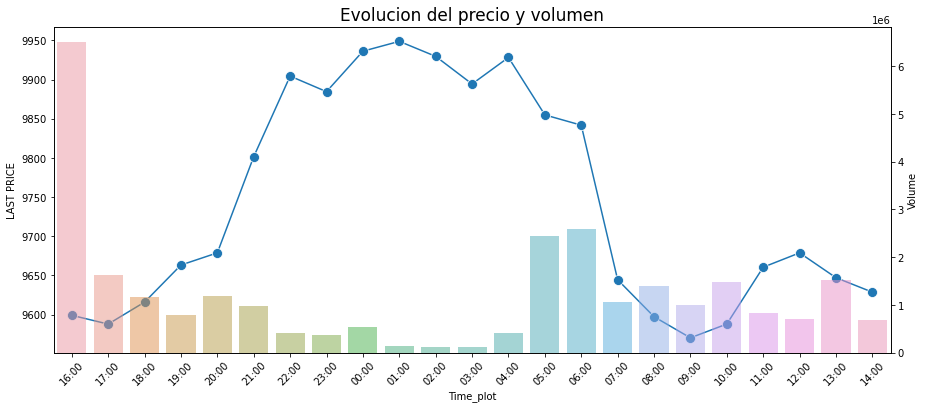

In [ ]:
# Se puede comprobar que la mayor actividad se produce por el dia
# y por la noche el volumen es mucho menor.

price = getDataPrice('EUR',me[0], 'hour', '24h')
display(price[0:4])
line_bar(price,0,-1)

In [ ]:
# ejemplo de extraccion de datos
#'EUR',me[0], 'day', '6m','c','5'
#'EUR',me[0], 'hour', '24h','c','5'
#'EUR',me[0], 'minute', '24h',bu[1],bp[1]
# Para Bitstamp en euros en las últimas 24horas por minuto valores de ASK y BID al 5%
A,B = getDataAB('EUR',me[0], 'minute', '24h','c','5')
print('Valores antes:')
display(A[0:5])
#display(B)
print('Valores despues de suavizados:')
A = homeTime(A['A5%c'],A['Time_plot'],'A5%c','24h')
B = homeTime(B['B5%c'],B['Time_plot'],'B5%c','24h')
display(A[0:5])
#display(B)

Valores antes:


,A5%c,Time_plot
Time,,
2020-07-31 16:12:00 UTC,3.539132e+06,16:12
2020-07-31 16:14:00 UTC,3.593976e+06,16:14
2020-07-31 16:16:00 UTC,3.647165e+06,16:16
2020-07-31 16:18:00 UTC,3.607097e+06,16:18
2020-07-31 16:20:00 UTC,3.691419e+06,16:20


Valores despues de suavizados:


,A5%c,Time_plot
0,3.539132e+06,16:12:00
1,3.566554e+06,16:13:00
2,3.593976e+06,16:14:00
3,3.620571e+06,16:15:00
4,3.647165e+06,16:16:00


In [ ]:
CALCULUS,AVERAGE_AB,DESVEST_AB = AskBid_CALCULUS(A,B)
print('Base de datos de calculo del periodo:')
display(CALCULUS[0:5])
print('Medias de los datos anteriores:')
display(AVERAGE_AB)
print('Desviación típica:')
display(DESVEST_AB)

Base de datos de calculo del periodo:


,SPREAD 5%c,TOTAL 5%c,RELATION ASK/BID5%c,Time_plot
0,2.047856e+06,5.030409e+06,2.373223,16:12:00
1,2.116721e+06,5.016387e+06,2.459976,16:13:00
2,2.185586e+06,5.002366e+06,2.551833,16:14:00
3,2.235470e+06,5.005671e+06,2.613941,16:15:00
4,2.285354e+06,5.008976e+06,2.678173,16:16:00


Medias de los datos anteriores:


SPREAD 5%c             1.631085e+06
TOTAL 5%c              5.015035e+06
RELATION ASK/BID5%c    2.002151e+00
dtype: float64

Desviación típica:


SPREAD 5%c             528215.712921
TOTAL 5%c              579485.786181
RELATION ASK/BID5%c         0.398415
dtype: float64

In [ ]:
# Comprobación: ver la evolucion del euro en todos los mercados disponibles actualmente:
# mo[-4] dolar
# mo[11] euro
# Extracción de datos de los 4 primeros mercados:
exchangePrice={}
for i in me[0:4]:
    print(i)
    exchangePrice[i]=((getDataPrice(mo[-4], i, 'minute', '24h')))

bitstamp
bitfinex
kraken
coinbase


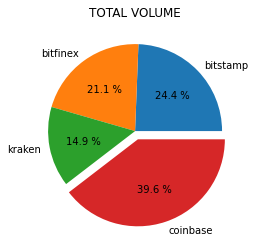

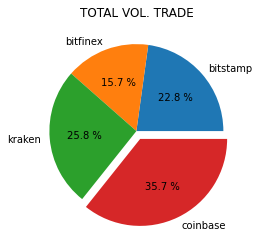

,AVERAGE PRICE,TOTAL VOLUME,RANGO DE PRECIOS,AVERAGE TRADEpm,TOTAL VOL. TRADE
EXCHANGE,,,,,
bitstamp,11474.2384,1.171199e+08,11318.5601 - 11629.9167,29.1353,12876.7196
bitfinex,11465.9181,1.015634e+08,11313.1211 - 11618.7151,69.9493,8849.3531
kraken,11476.0676,7.154695e+07,11320.2342 - 11631.901,46.7675,14552.0464
coinbase,11473.8882,1.900812e+08,11318.2583 - 11629.5181,130.4844,20152.9802


In [ ]:
# Datos de los 4 primeros mercados
datos_mercados,_= GeneralDataExchanges(mo[-4],me[0:4], 'minute', '24h')
graph_pie_exchanges(datos_mercados['TOTAL VOLUME'])
graph_pie_exchanges(datos_mercados['TOTAL VOL. TRADE'])
display(datos_mercados)

# Se puede comprobar que usualmente el mercado con mayor volumen es el de Coinbase.
# Además se puede entender que la media de los precios de los mercados sean casi iguales

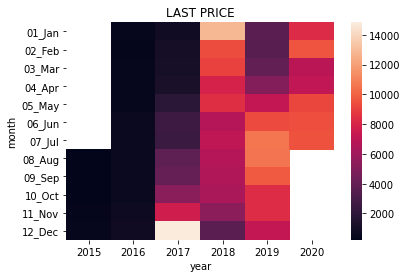

In [ ]:
# Se puede ver la evolucion del precio cada mes en el mercado de Bitstamp a lo largo de 5 años
price = getDataPrice(mo[-4],me[0], 'month', '5y')
graph_heat_map(price,'LAST PRICE')

# Dados los datos extraídos de los últimos 5 años:
# Se visualiza que el precio ha subido en gran medida los primeros años 2015-2017 
# (casi exponencial). Llegando a conseguir su cota maxima el último mes de ese año.
# Posteriormente el precio ha ido balanceandose.

La siguiente función se encuentra desactivada para evitar problemas al comienzo del inicio
del kernel. Los datos generados por esta función ya se encuentran en la carpeta Grafica_3ejes.

In [ ]:
###EXTRAER DATOS DEL 1 Y 5% EN FIAT DE ASK/BID PARA 6M,2AÑOS Y 5 AÑOS DE BITSTAMP EN EUROS
###Fichero raiz de los datos de guardado
#directorio = '../Proyecto_Final_Python/Datos/Grafica_3ejes/'
#
# 
#for i in ['1','5']:
#    for j in ['6m','2y','5y']:
#        try:
#            print('Grafica para ' + i + '% y timespan ' + j)
#            time.sleep(2)
#            graph3_rel_TotalAB_price('EUR',me[0],'day',j,bu[1],i,directorio)
#        except Exception as e:
#            print(e)
#            print('Se paro en ' + i + '% y timespan ' + j)

In [ ]:
# Funcion que extrae los datos en bucle infinito
# data_graph3_mo_me(mo[-4],me[0],bp[1], directorio)

In [ ]:
# PREDICCIÓN
# ¿Que modelo de regresión sería el mejor en cada caso? 
# Teniendo en cuenta las siguientes opciones:
supply=['SPREAD ','TOTAL ', 'RELATION ASK/BID']
modelo =['lineal','poly2','poly3','KNN']
for i in supply:
    for j in ['6m','2y','5y']:
        time.sleep(1)
        lista = predictModel('EUR',me[0], 'day', j,bu[1],bp[1],'pol3',i)
        print('-------------------------------------------------------')
        print('Con el lapso de tiempo: ' + j + 'y con datos añadidos de ' + i)
        print('CONFIANZA: ')
        print(max(lista))
        pos_max=lista.index(max(lista))
        print(' + Hay mayor confianza con el modelo: ' + modelo[pos_max])
        pos_min=lista.index(min(lista))
        print(' - El de menor confianza con el modelo: ' + modelo[pos_min])
        
        # El modelo de KNN es el que mejor funciona con los datos de 6meses, 2 años y 5 años.
        # Aparentemente los datos de SPREAD dan mayor confianza al conjunto de la predicción.

HTTPError: ignored

,SPREAD 10%c,TOTAL 10%c,RELATION ASK/BID10%c,Time_plot
Time,,,,
2020-02-01 00:00:00 UTC,4.870198e+05,5.216484e+06,1.205951,2020-02-01
2020-02-02 00:00:00 UTC,6.715932e+05,5.158375e+06,1.299365,2020-02-02
2020-02-03 00:00:00 UTC,7.780588e+05,6.252862e+06,1.284233,2020-02-03
2020-02-04 00:00:00 UTC,4.249602e+05,6.359714e+06,1.143211,2020-02-04
2020-02-05 00:00:00 UTC,5.145610e+05,6.814676e+06,1.163350,2020-02-05
...,...,...,...,...
2020-07-27 00:00:00 UTC,3.856370e+06,1.006459e+07,2.242344,2020-07-27
2020-07-28 00:00:00 UTC,1.970429e+06,7.439191e+06,1.720612,2020-07-28
2020-07-29 00:00:00 UTC,1.901890e+06,8.521810e+06,1.574596,2020-07-29


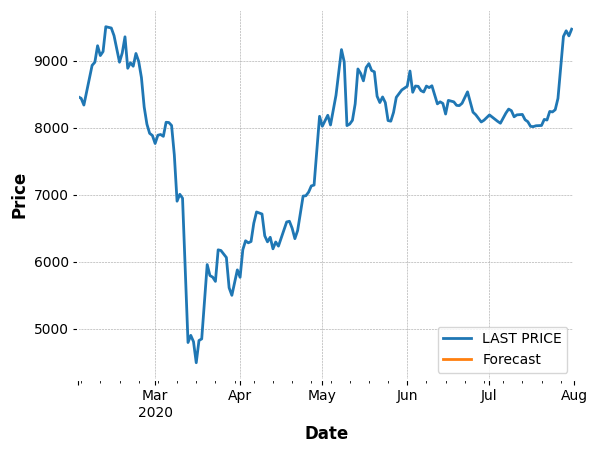

Prediccion para las 2020-08-01 00:00:00 con knn es:  [9233.82317226 8761.811575  ]
Con una confianza para KNN:  0.9532925050021279
Con una confianza para poly2:  0.9036564919192474
Con una confianza para poly3:  0.913335028267766
Con una confianza con regresion lineal:  0.8990753617401375


[0.8990753617401375, 0.9036564919192474, 0.913335028267766, 0.9532925050021279]

In [ ]:
## KNN
# currency: Lista de monedas o dinero fiat
mo = ['AED','ARS','AUD','BRL','CAD','CHF','CLP','CNY','COP','CZK','DKK','EUR','GBP','HKD',
         'HRK','HUF','IDR','ILS','INR','IRR','JPY','KES','KRW','MXN','MYR','NOK','NZD','PHP',
         'PKR','PLN','RON','RUB','RUR','SEK','SGD','THB','TRY','UAH','USD','VEF','XAU','ZAR']

# exchange: Mercados disponibles (los 4 primeros son los más comunes)
# ['bitfinex', 'bitstamp', 'coinbase', 'kraken']
me = ['bitstamp','bitfinex','kraken','coinbase','bit-x','exmo','cex.io','gemini','bitcoin.co.id','bitflyer',
            'bitcoincentral','bit2c','bitcoinde','bitcoinsnorway','bitcurex',
            'bitflyer','bithumb','bitmarketpl','bitmex','bitquick','bitso','btcchina','btce',
            'btcmarkets','campbx','clevercoin','coinfloor','hitbtc','huobi','itbit',
          'korbit','lakebtc','localbitcoins','mercadobitcoin','okcoin','paymium',
          'quadrigacx','therocktrading','vaultoro','wallofcoins','bitbay']

# Otras variables disponibles para la configuracion de ASK y BID:
# Contabilización en bids/asks en criptomonedas o dinero fiat bu ='b' / bu ='c'
bu = ['b','c']

# Porcentajes de bids y asks 1%,5%,10%,20%,50% respectivamente.
bp = ['1','5','10','20','50']

predictModel('EUR',me[0], 'day','6m',bu[1],bp[2],'knn','SPREAD ')

#predictModel(currency, exchange, register, timespan,bu,porcent,model,supply):

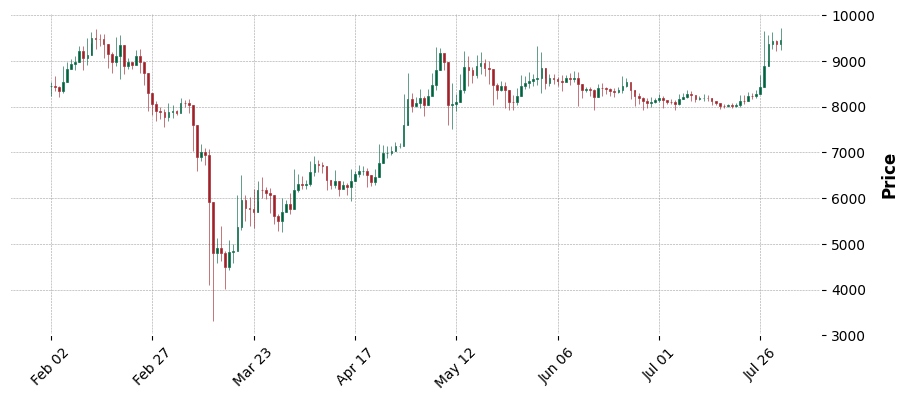

In [ ]:
# ANALISIS DE LA EVOLUCIÓN DEL BITCOIN
# Grafico de velas para los 5 ultimos años por dias en euros en el mercado de Bitstamp
OC_price,_ = OpenCloseOtherPrice('EUR',me[0], 'day', '6m')
OC_price.index.name = 'Date'
mpf.plot(OC_price,type='candle',style='charles',figratio=(49,20),figscale=0.8)



In [ ]:
# Con una escala logaritmica se visualizan algo mejor los cambios y se pueden llegar a 
# realizar comparaciones entre cada periodo

OC_price,_ = OpenCloseOtherPrice('EUR',me[0], 'day', '5y')
OC_price.index.name = 'Date'
fig, axlist =mpf.plot(OC_price,type='candle',style='charles',figratio=(49,20),figscale=0.8,returnfig=True)

ax1 = axlist[0]
ax1.set_yscale('log', basey=2)
plt.show()

In [ ]:
# Si se toma todo el dataset de precios existentes en Blockchain desde sus origenes hasta el
# dia de hoy (6-5-20) y lo graficamos, aparentemente se puede comprobar que el precio aumenta
# con el tiempo pero no se puede valorar de manera determinada que tipo de tendencia 
# tendra en el futuro.
%matplotlib inline
ruta = '../Proyecto_Final_Python/Datos/market-price.csv'
datablock = pd.read_csv(ruta,index_col = 0, header = 0, engine = 'python')
plt.plot(datablock)
plt.xlabel('Tiempo') #(cada 3 dias)
plt.ylabel('Precios (USD)')
plt.title('Evolución del precio del bitcoin')
plt.show()

In [ ]:
# Sin embargo si graficamos los datos con una escala logaritmica se puede comprobar
# que el precio del bitcoin aparentemente sigue una tendencia de subida.

%matplotlib notebook
%matplotlib notebook
plt.plot(datablock)
plt.xlabel('Tiempo') #(cada 3 dias)
plt.ylabel('Precios (USD)')
plt.title('Evolución del precio del bitcoin')
plt.show()
plt.yscale('log', basey=2)

,MM,B.I.,B.S.,Open,Close
Date,,,,,
2018-08-02,0.00,0.00,0.00,6472.469008,6527.410311
2018-08-03,0.00,0.00,0.00,6527.410311,6379.135130
2018-08-04,0.00,0.00,0.00,6379.135130,6256.800006
2018-08-05,0.00,0.00,0.00,6256.800006,6042.672728
2018-08-06,0.00,0.00,0.00,6042.672728,6047.534112
...,...,...,...,...,...
2020-07-27,8176.18,7895.09,8457.27,8436.622791,8898.894113
2020-07-28,8215.12,7756.33,8673.91,8898.894113,9361.447599
2020-07-29,8257.81,7665.70,8849.92,9361.447599,9445.734444


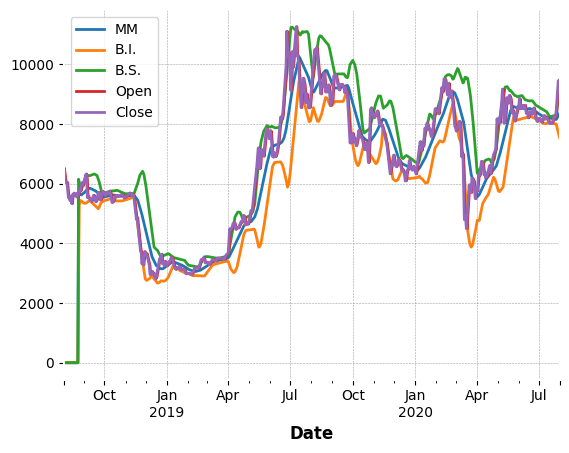

In [ ]:
# Grafico de candelas para los ultimos 6 meses en euros en el mercado de Bitstamp
# ncells = 5 # dimensiones del estudio (ejemplo: 1min cada celda, ncells=5 -> 5min)
# longitud_mm = 20 # numero de datos para hacer mm
# MULTI = 2
currency='EUR'
duration='2y' #timespan
interval='day' #register
OC_price,_ = OpenCloseOtherPrice(currency,me[0], interval, duration)
OC_price.index.name = 'Date'
price = getDataPrice(currency,me[0], interval, duration)
bolling,_ = bol(5,20,2,price,duration)
bolling.index.name = 'Date'

result = pd.concat([bolling[1:], OC_price], axis=1, sort=False)
del result['High']
del result['Low']
del result['Volume']
display(result)

result.plot()
# Indicativos:
# En los momento donde el precio baja por debajo de la banda inferior es buen momento para comprar
# En los momentos donde el precio sube por encima de la banda superior es buen momento para vender

In [ ]:
# Con los graficos de a continuación se pueden comprobar otros tipos de visualizaciones
# que se pueden llegar a conseguir con el modulo de mpfinance
currency='EUR'
OC_price,_ = OpenCloseOtherPrice(currency,me[0], 'min', '1h')
mpf.plot(OC_price,type='ohlc',mav=4)

In [ ]:
# Grafico de velas con sus respectivos volumnenes
mpf.plot(OC_price,type='candle',mav=(3,6,9),volume=True,style='charles')